## Deep Q-Learning (Ex. 4) 
--------------------------------------------------------------------
#### Approach
1. Separate Network class and Agent class
2. Network class defines NN and **importantly** how the Q-table is represented as a function approximation

**Network class**
- Input dimensions: xxx
- First layer: Nodes = **input dim.** and fully connected onward to 2nd layer with 128 nodes
    - ```self.fc_1 = nn.Linear(*input_dims, 128)```
- Second layer: 128 nodes fully connected onward to final output layer
    - ```self.fc_2 = nn.Linear(128, n_actions)```
- Output layer: nodes = n_actions
- **Important concept**:
   - Output layer estimates Q values
   - Q = state-action value function
   - Given the environment i.e. state as input, 
   - **Output the "*value*" of each action for each state** 
   
**Agent class**
- Agent itself is not a Q estimate
- Agent _has_ a Q estimate, along with other things: learning, epsilon handling etc.

In [63]:
import gym
import numpy as np

import torch.nn as nn
import torch.nn.functional as functional # For activations functions
import torch.optim as optim
import torch as T

# Import custom utilities
from utilities import plot_learning_curve

In [59]:
N_EPISODES = 10000
N_AVG_REWARDS = 100

### Network Class

In [45]:
class LinearDQN (nn.Module):
    
    # Step 1: Initialize NN. classes=n_actions, input_dims=n_states
    def __init__(self, lr=0.001, n_actions=4, input_dims=2):
        super(LinearDQN, self).__init__();
        
        # 1.1. Two  fully-connected (fc) layers
        self.fc_1 = nn.Linear(*input_dims, 128)
        # Output layer estimates Q values. 
        # Q = state-action value functions
        # Given a state as input, value of each action for each state
        self.fc_2 = nn.Linear(128, n_actions)
        
        # 1.2. Optimizer. self.parameters() tells optimizer what we are optimizing
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
        # 1.3. Loss function: Alternative CrossEntropyLoss(), huber-loss etc.
        self.loss = nn.MSELoss()
        
        # 1.4. Detect GPU and use if available
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        
        # 1.5. Send entire nn to this device
        self.to(self.device)
    
    # PyTorch handles back-prop for us, but feed-forward also. we must provide
    # Step 2: Feed-forward algo.
    def feedforward(self, state):
        # 2.1. Activate each layer and feed-forward into next
        # 2.2. Output of last layer is NOT activate.
        # The MSE loss function activates this and converts it 
        #   into probabilities that will add up to 1.0
        layer_1 = functional.relu(self.fc_1(state))
        actions = self.fc_2(layer_1)        
        return (actions)

### Agent Class

#### Bellman eq. and mapping it's components to the code elements

**1. Bellman Equation**:
- Q(s,a) <- Q(s,a) + alpha * [R + gamma * Q(s',a_max) - Q(s,a)]

**2. Equation from tabular Q implementation**:

```self.Q[(state, action)] += self.alpha*(reward + self.gamma*self.Q[(next_state, action_max)] - self.Q[(state, action)])```

**3. Code versions**: _(Note my versions are different with more explanatory steps and variable names)_
<pre>
- q_pred = self.Q.forward(state)[action]
- q_next = self.Q.forward(next_state).max()
- q_target = reward + self.gamma*q_next
</pre>
**4. Mapping**:
- ```q_pred``` = Q predicted = Q(s,a) 
- ```q_pred``` = current state, where action is **as is**
- ```q_next``` = Q(s', a_max) part. Here ```max()``` is used to identify best / greedy action
- ```q_target``` = Target part = R + gamma *  Q(s',a_max) 
- <pre>q_target = (R + gamma *  q_next) </pre>
- Loss = [R + gamma *  Q(s',a_max)] - Q(s,a)
- <pre>loss = q_target - q_pred </pre>


In [57]:
class Agent:
    def __init__(self, input_dims, n_actions, alpha=0.0001, gamma=0.99, 
                 epsilon=1.0, eps_dec=1e-5, eps_min=0.1):
        self.alpha = alpha
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        # Define a "action space" as a list
        self.action_space = [n for n in range(self.n_actions)]
        
        # For the simple Q tabular learning; Q = dictionary. Defined simply as self.Q = {}
        # Here we use the NN!
        self.Q = LinearDQN(self.alpha, self.n_actions, self.input_dims)
                
    def decide_action(self, state):
        # Take greedy action if > epsilon
        if np.random.random() > self.epsilon:
            state_tensor = T.tensor(state, dtype=T.float).to(self.Q.device)
            
            # Find the Q values for the given state (i.e. action values)
            # Get action value vector by feed-forward propogation
            Q_action_values = self.Q.feedforward(state_tensor)
            
            # Find the position of the max. Q value.
            # Get particular max action index, use tensor derefencing using .item() to get numpy format
            action = T.argmax(Q_action_values).item()
        else:
            # Explore, choose a random action
            action = np.random.choice(self.action_space)
            
        return action
    
    # Decrease episilon linearly
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_min else self.eps_min
    
    # Bellman equation
    def learn(self, state, action, reward, next_state):
        
        # 1. Initialize gradients to zero; before begining learning loop  
        #    Reduces chance of cross-chatter or gradients mis-behaving or leaking from one iteration to another
        self.Q.optimizer.zero_grad()
        
        # 2. Convert arguments which are numpy arrays to PyTorch cuda tensors
        state_tensor = T.tensor(state, dtype=T.float).to(self.Q.device)
        action_tensor = T.tensor(action).to(self.Q.device)
        reward_tensor = T.tensor(reward).to(self.Q.device)
        next_state_tensor = T.tensor(next_state, dtype=T.float).to(self.Q.device)
        
        # Bellman Equation and mapping to it
        # q_pred = Q predicted = Q(s,a) 
        # q_pred = current state, where action is **as is**
        # q_next = Q(s', a_max) part. Here max() is used to identify best / greedy action
        # q_target = Target part = R + gamma *  Q(s',a_max) 
        # q_target = (R + gamma *  q_next)
        # Loss = [R + gamma *  Q(s',a_max)] - Q(s,a)
        # loss = q_target - q_pred
        
        # 3. Get predictions, i.e. outputs
        # Feed forward to calculate the update Bellman equation for the Q estimate
        # Q is the final output layer so will contain Q values for ALL actions
        Q_predicted_for_all_actions = self.Q.feedforward(state_tensor)
        # Get Q value for action that was selected
        Q_predicted = Q_predicted_for_all_actions[action_tensor]
        
        # 4 Get max. Q value for next state
        Q_predicted_for_next_state_for_all_actions = self.Q.feedforward(next_state_tensor)
        Q_next_state = Q_predicted_for_next_state_for_all_actions.max()
        
        # 5. Target is the (R + gamma*Q(s',a) part
        Q_target = reward_tensor + self.gamma*Q_next_state
        
        # 6. Compute loss = error = cost = (q_target - q_pred)
        loss = self.Q.loss(Q_target, Q_predicted).to(self.Q.device)
      
        # 7. Backward propogate, note loss is already self.Q.loss, so can call .backward() directly
        loss.backward()
        
        # 8. Call optimizer to optimize
        self.Q.optimizer.step()
        
        # 9. Decrease epsilon
        self.decrement_epsilon()

### Main loop

0000: Reward 22.00 | Avg. reward 22.00 | Epsilon 1.000
0100: Reward 13.00 | Avg. reward 21.67 | Epsilon 0.978
0200: Reward 35.00 | Avg. reward 21.51 | Epsilon 0.957
0300: Reward 39.00 | Avg. reward 21.67 | Epsilon 0.935
0400: Reward 19.00 | Avg. reward 21.99 | Epsilon 0.913
0500: Reward 14.00 | Avg. reward 22.99 | Epsilon 0.890
0600: Reward 12.00 | Avg. reward 22.41 | Epsilon 0.868
0700: Reward 51.00 | Avg. reward 22.63 | Epsilon 0.845
0800: Reward 43.00 | Avg. reward 22.72 | Epsilon 0.822
0900: Reward 42.00 | Avg. reward 24.92 | Epsilon 0.797
1000: Reward 77.00 | Avg. reward 23.63 | Epsilon 0.774
1100: Reward 49.00 | Avg. reward 24.64 | Epsilon 0.749
1200: Reward 24.00 | Avg. reward 24.22 | Epsilon 0.725
1300: Reward 13.00 | Avg. reward 25.90 | Epsilon 0.699
1400: Reward 10.00 | Avg. reward 28.67 | Epsilon 0.670
1500: Reward 13.00 | Avg. reward 27.82 | Epsilon 0.642
1600: Reward 31.00 | Avg. reward 26.13 | Epsilon 0.616
1700: Reward 56.00 | Avg. reward 29.85 | Epsilon 0.586
1800: Rewa

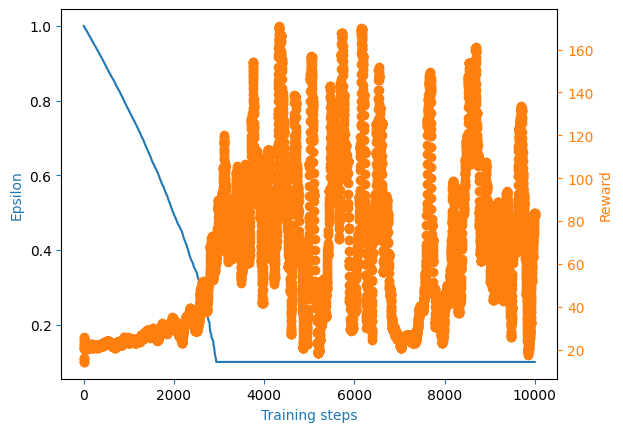

In [60]:
if __name__ == '__main__':
    rewards_history = []
    epsilon_history = []

    env = gym.make('CartPole-v1')
    agent = Agent(alpha=0.0001, input_dims = env.observation_space.shape, n_actions = env.action_space.n)

    for n in range(N_EPISODES):
        rewards = 0
        done = False
        observation = env.reset()
        
        while not done:
            # Choose action according to epsilon greedy policy
            action = agent.decide_action(observation)
            next_observation, reward, done, info = env.step(action) 
            rewards += reward
            agent.learn(observation, action, reward, next_observation)
            observation = next_observation
        # end while
        rewards_history.append(rewards)
        epsilon_history.append(agent.epsilon)
        
        if n % N_AVG_REWARDS == 0:
            average_reward = np.mean(rewards_history[-N_AVG_REWARDS:])
            print(f'{n:04d}: Avg. reward {average_reward:06.2f} | Epsilon {agent.epsilon:5.3f}')                   

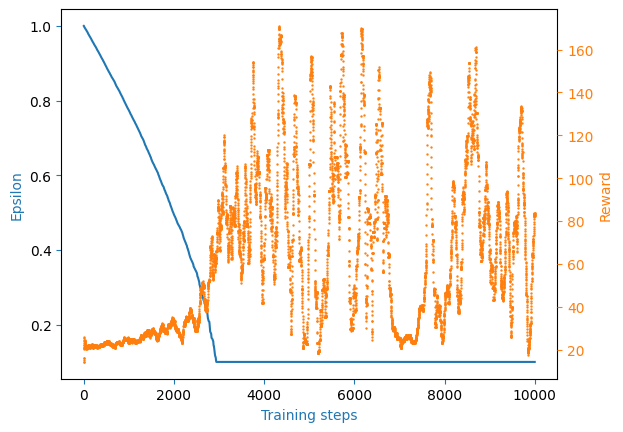

In [76]:
# Plot a learning curve, with x axis starting from 1 to N_EPISODES
x = [i+1 for i in range(N_EPISODES)]
plot_learning_curve(x, rewards=rewards_history, epsilons=epsilon_history, 
                    moving_avg_n=N_AVG_REWARDS, filename='CartPole_Naive_DQN.png') 